In [ ]:
import os
import pickle
from tqdm import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from PIL import Image
import numpy as np
import pandas as pd
from pathlib import Path
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [ ]:
!gdown https://drive.google.com/uc?id=1-PoTqtdg9D3FynRFfz0MiBInmRu7geGi -O journey-springfield.zip 

Downloading...
From: https://drive.google.com/uc?id=1-PoTqtdg9D3FynRFfz0MiBInmRu7geGi
To: /content/journey-springfield.zip
100% 546M/546M [00:04<00:00, 119MB/s] 


In [ ]:
!unzip -q /content/journey-springfield.zip

In [ ]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [ ]:
TRAIN_DIR = Path('/content/train/simpsons_dataset')
TEST_DIR = Path('/content/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    DEVICE = torch.device("cpu")
else:
    print('CUDA is available!  Training on GPU ...')
    DEVICE = torch.device("cuda")

CUDA is available!  Training on GPU ...


In [ ]:
DEVICE

device(type='cuda')

In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
BATCH_SIZE = 256

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        # параметры аугментации для тренировочной выборки 
        train_transform = transforms.Compose([
            transforms.RandomChoice([
                transforms.Compose([
                    transforms.Resize(size=300, max_size=301),
                    transforms.CenterCrop(size=300),
                    transforms.RandomCrop(250)
                    ]),
                transforms.RandomRotation(degrees=(-25, 25)),
                transforms.RandomHorizontalFlip(p=1)
                ]),
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE))
        ])
        
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'train':
          x = train_transform(x)
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
    
    def _prepare_sample(self, image):
      H = image.size[1]
      W = image.size[0]
      if H > W:
        image = transforms.functional.pad(image,padding=[round(abs(H-W)/2),0])
      else:
        image = transforms.functional.pad(image,padding=[0,round(abs(H-W)/2)])
      image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
      return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
# разделим датасеты на тренировочную и валидационную выборку
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)
train_labels = [path.parent.name for path in train_files]


In [ ]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')

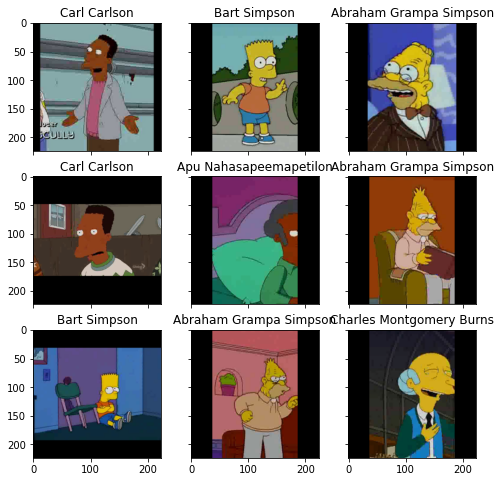

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
# взглянем на наши данные в тестовой выборке
df = pd.DataFrame(data={'image': train_files, 'label': train_labels})
df['label'].value_counts(ascending=True)

lionel_hutz                    2
disco_stu                      6
troy_mcclure                   6
miss_hoover                   13
fat_tony                      20
gil                           20
otto_mann                     24
sideshow_mel                  30
agnes_skinner                 32
rainier_wolfcastle            34
cletus_spuckler               35
snake_jailbird                41
professor_john_frink          49
martin_prince                 53
patty_bouvier                 54
ralph_wiggum                  67
carl_carlson                  74
selma_bouvier                 77
barney_gumble                 80
groundskeeper_willie          91
maggie_simpson                96
waylon_smithers              136
mayor_quimby                 185
lenny_leonard                233
nelson_muntz                 269
edna_krabappel               343
comic_book_guy               352
kent_brockman                373
apu_nahasapeemapetilon       467
sideshow_bob                 658
abraham_gr

In [ ]:
# добавим сэмплов в классы с малым колличеством в тренировочной выборке
class_count = Counter(train_dataset.labels)
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(train_dataset)
for i, label in enumerate(tqdm(train_dataset.labels)):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight

100%|██████████| 15699/15699 [00:00<00:00, 1757262.38it/s]


In [ ]:
# создадим даталоудеры
train_sampler = WeightedRandomSampler(sample_weights, num_samples=4 * len(df), replacement=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    scheduler.step()          
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_loader, val_loader, model, epochs, criterion, scheduler, optimizer):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:       

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
# сеть с некоторыми доработками на выходе
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.flat = nn.Flatten()
        self.drop1 = nn.Dropout(p=0.3)
        self.lin1 = nn.Sequential(
            nn.Linear(in_features=3200, out_features=8192, bias=True),
            nn.ReLU(inplace=True)
        )
        self.drop2 = nn.Dropout(p=0.3)
        self.lin2 = nn.Sequential(
            nn.Linear(in_features=8192, out_features=8192, bias=True),
            nn.ReLU(inplace=True)
        )
        self.drop3 = nn.Dropout(p=0.3)
        self.lin3 = nn.Sequential(
            nn.Linear(in_features=8192, out_features=4096, bias=True),
            nn.ReLU(inplace=True)
        )
        self.drop4 = nn.Dropout(p=0.3)
        self.out = nn.Linear(4096, n_classes, bias=True)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = self.flat(x)
        x = self.drop1(x)
        x = self.lin1(x)
        x = self.drop2(x)
        x = self.lin2(x)
        x = self.drop3(x)
        x = self.lin3(x)
        x = self.drop4(x)
        logits = self.out(x)
        return logits

In [ ]:
n_classes = 42
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print(simple_cnn)

SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flat): Flatten(start_dim=1, end_dim=-1)
  (drop1): Dropout

Запустим обучение сети.

In [ ]:
# параметры
opt = torch.optim.Adam(simple_cnn.parameters(), amsgrad=True, lr=1e-3)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

In [ ]:
history = train(train_loader, val_loader, model=simple_cnn, epochs=20, criterion=criterion, scheduler=scheduler, optimizer=opt)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 3.2598147769210915


epoch:   5%|▌         | 1/20 [09:37<3:02:56, 577.74s/it]


Epoch 001 train_loss: 3.2598     val_loss 2.5439 train_acc 0.1607 val_acc 0.3416
loss 1.4748939370279806


epoch:  10%|█         | 2/20 [19:30<2:55:54, 586.37s/it]


Epoch 002 train_loss: 1.4749     val_loss 1.6332 train_acc 0.7514 val_acc 0.6878
loss 1.006388717073112


epoch:  15%|█▌        | 3/20 [29:05<2:44:40, 581.21s/it]


Epoch 003 train_loss: 1.0064     val_loss 1.3562 train_acc 0.9094 val_acc 0.7847
loss 0.8676010722248059


epoch:  20%|██        | 4/20 [38:25<2:32:47, 572.96s/it]


Epoch 004 train_loss: 0.8676     val_loss 1.2336 train_acc 0.9514 val_acc 0.8242
loss 0.8064314795342272


epoch:  25%|██▌       | 5/20 [47:46<2:22:08, 568.60s/it]


Epoch 005 train_loss: 0.8064     val_loss 1.1428 train_acc 0.9687 val_acc 0.8582
loss 0.770672457838098


epoch:  30%|███       | 6/20 [56:56<2:11:11, 562.21s/it]


Epoch 006 train_loss: 0.7707     val_loss 1.1359 train_acc 0.9792 val_acc 0.8552
loss 0.7470585775303988


epoch:  35%|███▌      | 7/20 [1:05:53<2:00:03, 554.12s/it]


Epoch 007 train_loss: 0.7471     val_loss 1.1091 train_acc 0.9857 val_acc 0.8672
loss 0.7235881422224968


epoch:  40%|████      | 8/20 [1:15:28<1:52:07, 560.61s/it]


Epoch 008 train_loss: 0.7236     val_loss 1.0590 train_acc 0.9916 val_acc 0.8840
loss 0.7153412408225513


epoch:  45%|████▌     | 9/20 [1:25:03<1:43:37, 565.25s/it]


Epoch 009 train_loss: 0.7153     val_loss 1.0534 train_acc 0.9939 val_acc 0.8831
loss 0.7119467481092796


epoch:  50%|█████     | 10/20 [1:34:55<1:35:34, 573.48s/it]


Epoch 010 train_loss: 0.7119     val_loss 1.0464 train_acc 0.9946 val_acc 0.8869
loss 0.7085368602896536


epoch:  55%|█████▌    | 11/20 [1:44:14<1:25:21, 569.10s/it]


Epoch 011 train_loss: 0.7085     val_loss 1.0457 train_acc 0.9957 val_acc 0.8863
loss 0.707109170109157


epoch:  60%|██████    | 12/20 [1:53:29<1:15:18, 564.80s/it]


Epoch 012 train_loss: 0.7071     val_loss 1.0439 train_acc 0.9960 val_acc 0.8886
loss 0.7052202884145083


epoch:  65%|██████▌   | 13/20 [2:03:02<1:06:10, 567.21s/it]


Epoch 013 train_loss: 0.7052     val_loss 1.0452 train_acc 0.9968 val_acc 0.8907
loss 0.7031123924311562


epoch:  70%|███████   | 14/20 [2:12:32<56:48, 568.07s/it]


Epoch 014 train_loss: 0.7031     val_loss 1.0448 train_acc 0.9969 val_acc 0.8898
loss 0.7024814489009433


epoch:  75%|███████▌  | 15/20 [2:22:34<48:11, 578.33s/it]


Epoch 015 train_loss: 0.7025     val_loss 1.0430 train_acc 0.9971 val_acc 0.8894
loss 0.702315587603793


epoch:  80%|████████  | 16/20 [2:32:10<38:30, 577.59s/it]


Epoch 016 train_loss: 0.7023     val_loss 1.0419 train_acc 0.9972 val_acc 0.8901
loss 0.7020026100722914


epoch:  85%|████████▌ | 17/20 [2:41:26<28:33, 571.06s/it]


Epoch 017 train_loss: 0.7020     val_loss 1.0406 train_acc 0.9972 val_acc 0.8905
loss 0.7019094687767473


epoch:  90%|█████████ | 18/20 [2:51:01<19:04, 572.35s/it]


Epoch 018 train_loss: 0.7019     val_loss 1.0400 train_acc 0.9972 val_acc 0.8896
loss 0.7012292590898513


epoch:  95%|█████████▌| 19/20 [3:00:05<09:23, 563.64s/it]


Epoch 019 train_loss: 0.7012     val_loss 1.0402 train_acc 0.9975 val_acc 0.8903
loss 0.7011201235889455


epoch: 100%|██████████| 20/20 [3:09:39<00:00, 568.99s/it]


Epoch 020 train_loss: 0.7011     val_loss 1.0397 train_acc 0.9977 val_acc 0.8905


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

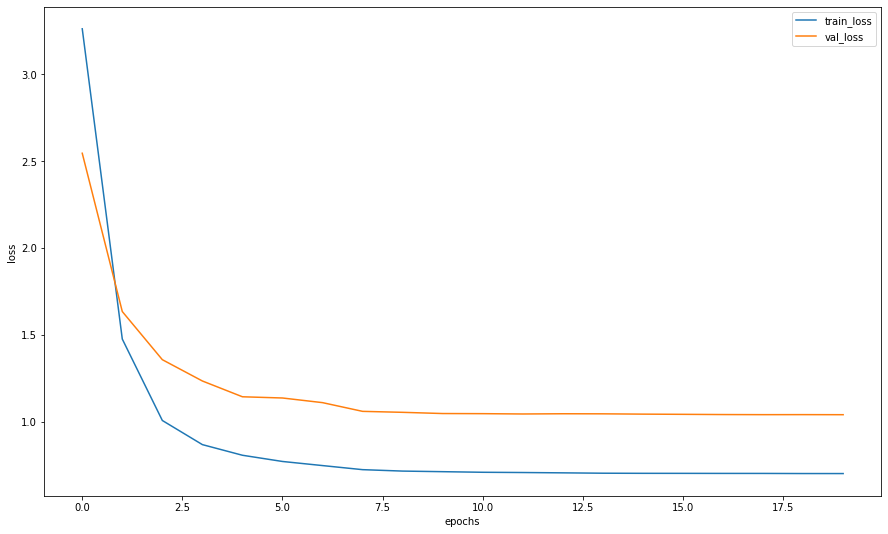

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

0.9

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls 

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
journey-springfield.zip      sample_data	testset


In [ ]:
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
#my_submit.to_csv('/content/simple_cnn_3lin.csv', index=False)

Ник на Kaggle: Ilya Terkin

Team Name: Илья_Федотов_405593976

Stepik ID: 405593976

Score: 0.98087